In [1]:
import math
import torch
import matplotlib.pyplot as plt
import pdb
import pandas as pd  
import seaborn as sns 
import numpy as np

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


dataset torch.Size([3, 2])


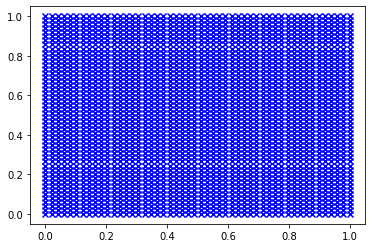

In [125]:
# from https://kornia.readthedocs.io/en/latest/_modules/kornia/utils/grid.html
from typing import Optional

def create_meshgrid(
        height: int,
        width: int,
        normalized_coordinates: Optional[bool] = True,
        device: Optional[torch.device] = torch.device('cpu')) -> torch.Tensor:
    """Generates a coordinate grid for an image.

    When the flag `normalized_coordinates` is set to True, the grid is
    normalized to be in the range [-1,1] to be consistent with the pytorch
    function grid_sample.
    http://pytorch.org/docs/master/nn.html#torch.nn.functional.grid_sample

    Args:
        height (int): the image height (rows).
        width (int): the image width (cols).
        normalized_coordinates (Optional[bool]): whether to normalize
          coordinates in the range [-1, 1] in order to be consistent with the
          PyTorch function grid_sample.

    Return:
        torch.Tensor: returns a grid tensor with shape :math:`(1, H, W, 2)`.
    """
    # generate coordinates
    xs: Optional[torch.Tensor] = None
    ys: Optional[torch.Tensor] = None
    if normalized_coordinates:
        xs = torch.linspace(-1, 1, width, device=device, dtype=torch.float)
        ys = torch.linspace(-1, 1, height, device=device, dtype=torch.float)
    else:
        xs = torch.linspace(0, width - 1, width, device=device, dtype=torch.float)
        ys = torch.linspace(0, height - 1, height, device=device, dtype=torch.float)
    # generate grid by stacking coordinates
    base_grid: torch.Tensor = torch.stack(
        torch.meshgrid([xs, ys])).transpose(1, 2)  # 2xHxW
    return torch.unsqueeze(base_grid, dim=0).permute(0, 2, 3, 1)  # 1xHxWx2

def add_gaussian_noise(tensor, mean=0., std=1.):
    return tensor + torch.randn(tensor.size()) * std + mean

dataset = [[0.25, 0.4], [0.75, 0.75], [0.85, 0.65]]
original_dataset = dataset = torch.tensor(dataset).float()
print("dataset", dataset.shape)

grid_size = 50
patterns = create_meshgrid(grid_size, grid_size, normalized_coordinates=False).reshape(-1, 2) / (grid_size-1)

# patterns = torch.rand((50, 2))

# patterns = torch.tensor([[0.25, 0.30]])

# patterns
plt.scatter(patterns[:, 0], patterns[:, 1], marker='x', c='b')
original_patterns = patterns.clone()

In [0]:
def similarity(x, patterns, subset_threshold=0.2):
  # Formula derivation https://www.desmos.com/calculator/iokn9kyuaq
  # print("x", x)
  dist = ((x - patterns) ** 2).sum(dim=-1)
  # print("patterns", patterns)
  # print("dist", dist)
  #dist = dist.sum(dim=-1) # TODO: use subset activation # TODO: apply mask (inverse variance)
  winner_index = dist.min(dim=0)[1]
  # print("winner_index", winner_index)

  winning_pattern = patterns[winner_index]
  a_scale = 0.2
  a = a_scale * ((x - winning_pattern) ** -2)
  a[a > 15000.0] = 15000.0
  # print("a", a)
  s = 0.8
  sim = (-a * ((x - patterns) ** 2)).mean(dim=-1)
  # print("sim1", sim)
  # scale = 0.685
  scale = 1.0
  sim = (torch.exp(sim) - s * torch.exp(sim * 0.9)) / ((1 - s) * scale)
  sim[sim>1.0] = 1.0

  # print("sim", sim)

  return sim, winner_index, dist

sim, winner_index, dist = similarity(dataset[0], patterns)

Iteration  0


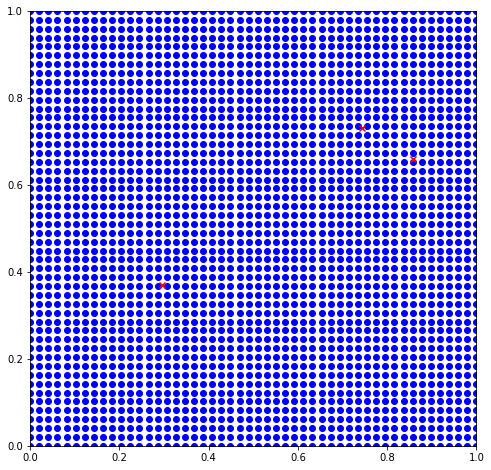

Iteration  1000


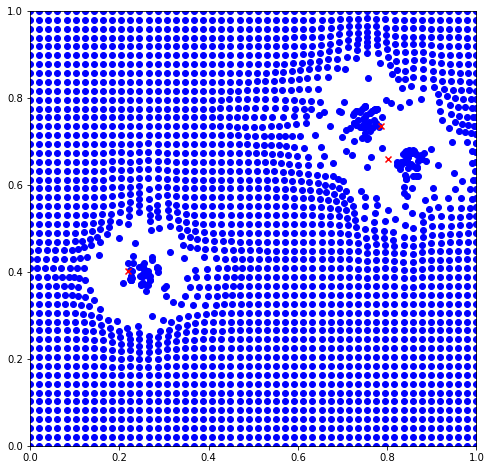

Iteration  2000


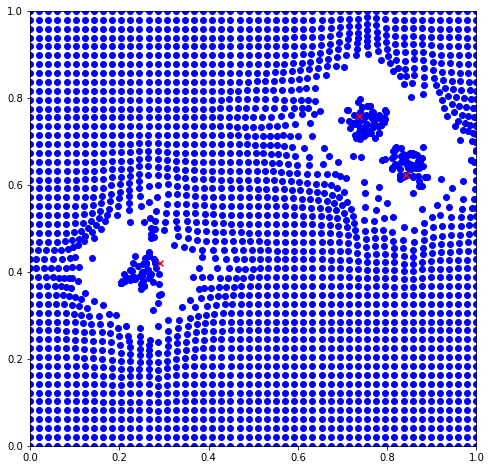

Iteration  3000


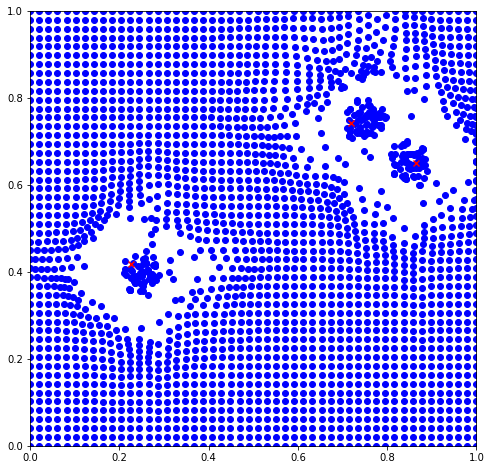

Iteration  4000


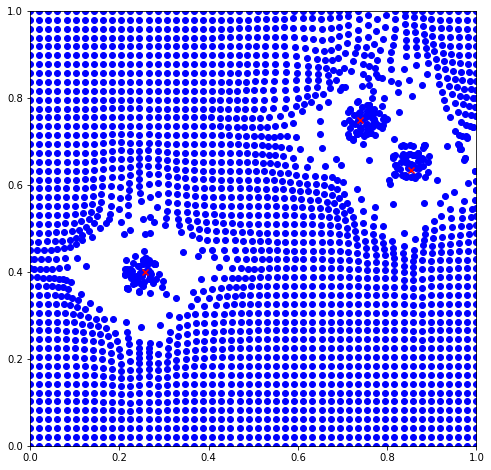

Iteration  5000


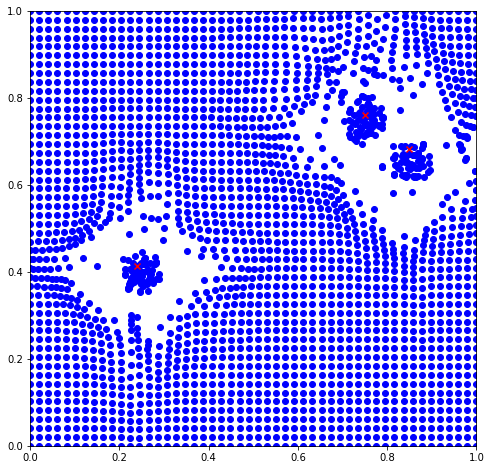

Iteration  6000


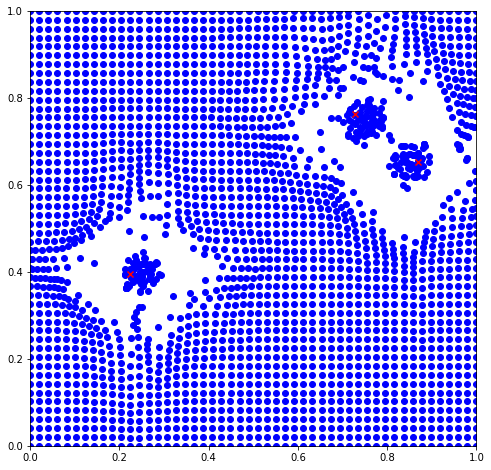

Iteration  7000


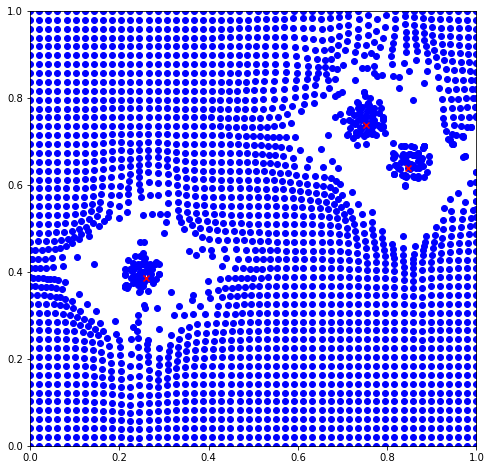

Iteration  8000


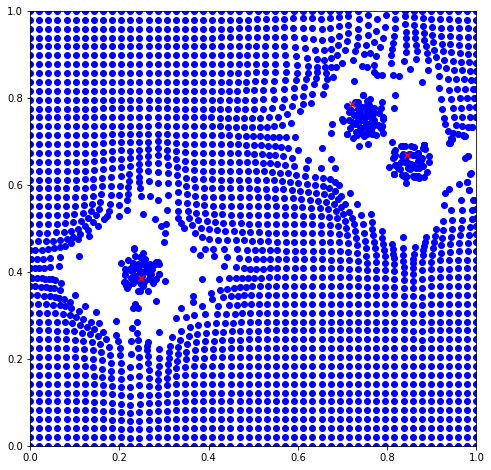

Iteration  9000


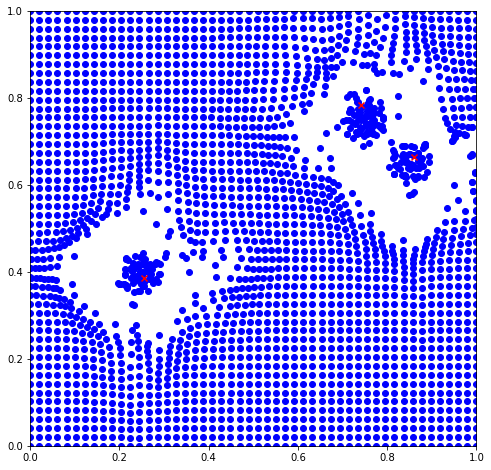

In [127]:
patterns = original_patterns
pattern_lr = torch.ones((patterns.shape[0],))

def plot_patterns(patterns, dataset):
  plt.figure(figsize=(8,8))
  plt.scatter(patterns[:, 0], patterns[:, 1], marker='o', c='b')
  plt.scatter(dataset[:, 0], dataset[:, 1], marker='x', c='r')
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.show()

def run_dataset(dataset, patterns, pattern_lr):
  for x in dataset:
    # print("-------")
    sim, winner_index, dist = similarity(x, patterns)
    sim = sim.unsqueeze(-1)
    # print("dist[winner_index]", dist[winner_index] * 100)
    pattern_lr[winner_index] = 0.9 * pattern_lr[winner_index] + 0.1 * (1.0 - torch.exp(-dist[winner_index]))

    # print("x", x)
    # print("(x - patterns)", (x - patterns))
    # print("sim", sim)
    delta = (x - patterns) * sim * lr * pattern_lr.unsqueeze(-1)
    # print("delta", delta)
    patterns = patterns + delta

  patterns.clamp_(0, 1)
  pattern_lr.clamp(0, 1)
  # print("patterns", patterns)
  # print("pattern_lr", pattern_lr)
  return patterns, pattern_lr

lr = 1
epochs = 10000
for i in range(epochs):
  dataset = add_gaussian_noise(original_dataset, std=0.02)
  if i % int(epochs / 10) == 0:
    print("Iteration ", i)
    plot_patterns(patterns, dataset)
  patterns, pattern_lr = run_dataset(dataset, patterns, pattern_lr)



tensor([1., 1., 1.,  ..., 1., 1., 1.])

Under moderately noisy conditions, we still see neighborhood clearing